# Pipeline for the anomaly detection on the local data using Convolutional Autoencoder

In [7]:
# libraries importing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from io import StringIO
import requests
from tsad.evaluating.evaluating import evaluating

# Data loading

In [8]:
def dataframe_expirement(i):
    if i == 1:
        url = "https://storage.yandexcloud.net/cloud-files-public/dataframe.csv" 
        df = pd.read_csv(StringIO(requests.get(url).content.decode('utf-8')), sep='|')
        df = df[df[df.columns[0]] == 'xxxAA684G'] #xxxAA684G

        df.replace(['-9999', -9999,'missing','#'], np.nan, inplace=True)
        df = df[df['unitless'].notna()]
        df = df[df['uR/h'].notna()]
        df = df[df['ohmm'].notna()]
        df = df.drop(axis=1, labels=(df.columns[0])) \
            .drop(axis=1, labels=(df.columns[1]))[['uR/h', 'unitless','ohmm']].reset_index(drop=True)
        return df
    else:
        url = "https://storage.yandexcloud.net/cloud-files-public/noname_ECG_2022.csv" 
        dataframe_edited_ = pd.read_csv(StringIO(requests.get(url).content.decode('utf-8')), sep=',')
        return dataframe_edited_

In [9]:
ts_data_1, ts_data_2 = dataframe_expirement(1), dataframe_expirement(0).iloc[2500:].reset_index().drop(labels='index',axis=1)

# Data description and visualization

In [10]:
from scipy.signal import find_peaks

In [11]:
def plot_data_scores_and_selected_window(ts, score_list, window_size_selected):
    f, ax = plt.subplots(2, 1, figsize=(30, 20))
    ax[0].plot(ts)
    ax[0].vlines(x=window_size_selected, ymin=min(ts), ymax=max(ts),
        linestyle = ':',
        linewidth = 6,
        color = 'darkblue')
    ax[0].set_title("ts")
    ax[1].plot(score_list, "r")
    ax[1].set_title("score")
    f.show()

In [12]:
# dataset characteristics printing
print(f'A number of datasets: {2}\n')
print(f'Shape of the well dataset: {ts_data_1.shape}\n')
print(f'Shape of the medical dataset: {ts_data_2.shape}\n')
cp_1 = []
temp_value_second = 0
for i in range(len(ts_data_1)):
    temp_value = ts_data_1['unitless'][i]
    if temp_value != temp_value_second:
        cp_1.append(1)
    else:
        cp_1.append(0)
    temp_value_second = temp_value
cp_1[0] = 0
cp_2 = []
peaks, _ = find_peaks(ts_data_2['EcgWaveform'], distance=250)
for i in range(len(ts_data_2)):
    if i not in peaks:
        cp_2.append(0)
    else:
        cp_2.append(1)
ts_data_1['change_points'] = cp_1
ts_data_2['change_points'] = cp_2
print(f'A number of datasets: {2}\n')
print(f'Shape of the well dataset: {ts_data_1.shape}\n')
print(f'Shape of the medical dataset: {ts_data_2.shape}\n')
n_cp_1 = cp_1.count(1)
n_cp_2 = cp_2.count(1)
print(f'A number of changepoints in the well dataset: {n_cp_1}\n')
print(f'A number of changepoints in the medical dataset: {n_cp_2}\n')
print(f'Head of the well dataset:')
display(ts_data_1.head())
print(f'Head of the well dataset:')
display(ts_data_2.head())

A number of datasets: 2

Shape of the well dataset: (10661, 3)

Shape of the medical dataset: (17500, 2)

A number of datasets: 2

Shape of the well dataset: (10661, 4)

Shape of the medical dataset: (17500, 3)

A number of changepoints in the well dataset: 74

A number of changepoints in the medical dataset: 37

Head of the well dataset:


,uR/h,unitless,ohmm,change_points
0,109.590,2.0,12.200000,0
1,110.990,2.0,11.017710,0
2,112.390,2.0,9.950000,0
3,112.895,2.0,9.223475,0
4,113.400,2.0,8.550000,0


Head of the well dataset:


,Time,EcgWaveform,change_points
0,04/08/2022 08:38:37.946,2450,0
1,04/08/2022 08:38:37.947,2447,0
2,04/08/2022 08:38:37.948,2445,0
3,04/08/2022 08:38:37.949,2442,0
4,04/08/2022 08:38:37.950,2440,0


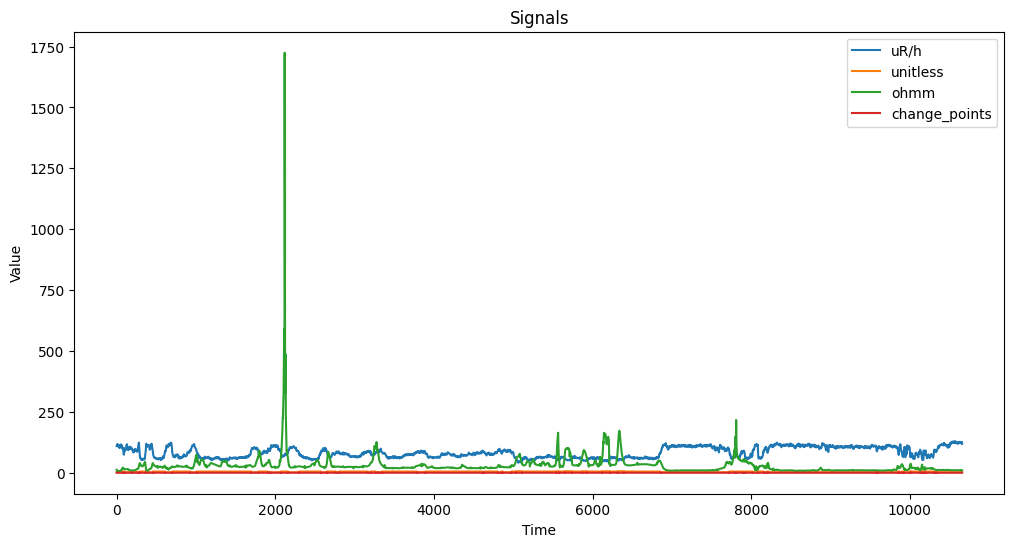

In [13]:
# well dataset visualizing
ts_data_1.plot(figsize=(12,6))
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Signals')
plt.show()

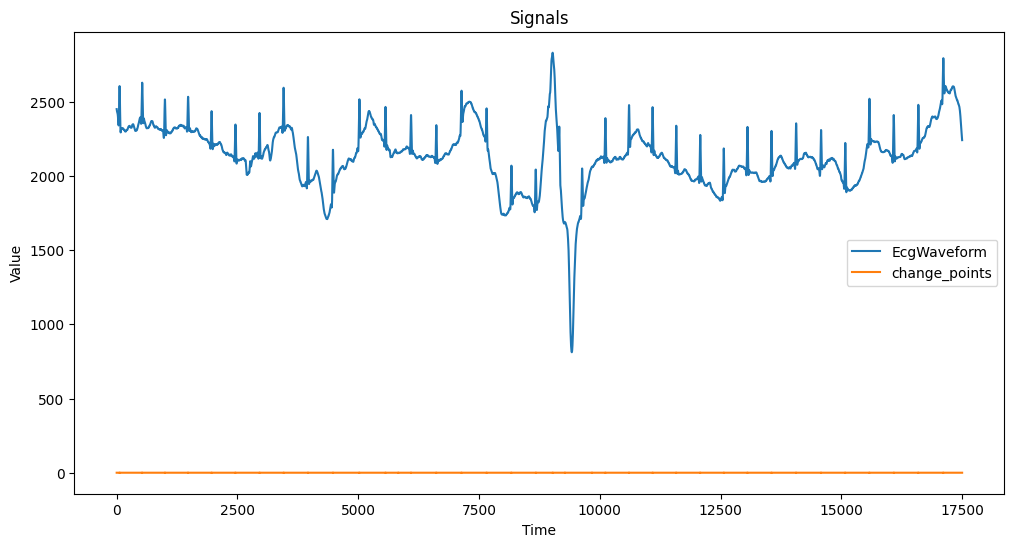

In [14]:
# medical dataset visualizing
ts_data_2.plot(figsize=(12,6))
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Signals')
plt.show()

In [15]:
list_of_df = [ts_data_1[['change_points','uR/h','ohmm']], ts_data_2.drop('Time', axis=1)]

# Method applying

In [16]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.signal import medfilt
from sklearn import decomposition
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from itertools import product

2023-04-03 19:47:21.228623: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-03 19:47:21.230035: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-03 19:47:21.256755: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-03 19:47:21.257623: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-03 19:47:21.748580: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [17]:
# Function for repeatability
def Random(seed_value):
    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    import os
    os.environ['PYTHONHASHSEED']=str(seed_value)

    # 2. Set `python` built-in pseudo-random generator at a fixed value
    import random
    random.seed(seed_value)

    # 3. Set `numpy` pseudo-random generator at a fixed value
    import numpy as np
    np.random.seed(seed_value)

    # 4. Set `tensorflow` pseudo-random generator at a fixed value
    import tensorflow as tf
    tf.random.set_seed(seed_value)

In [18]:
def arch(data):
    Random(0)
    model = keras.Sequential(
        [
            layers.Input(shape=(data.shape[1], data.shape[2])),
            layers.Conv1D(
                filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Dropout(rate=0.2),
            layers.Conv1D(
                filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Conv1DTranspose(
                filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Dropout(rate=0.2),
            layers.Conv1DTranspose(
                filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
        ]
    )
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
    # model.summary()

    history = model.fit(
        data,
        data,
        epochs=100,
        batch_size=32,
        validation_split=0.1,
        verbose=0,
        callbacks=[
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min", verbose=0)
        ],
    )
    return history, model

# Training in the beginning of each dataset

In [19]:
N_STEPS = 60
Q = 0.999 # quantile for upper control limit (UCL) selection

In [20]:
# Generated training sequences for use in the model.
def create_sequences(values, time_steps=N_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

In [21]:
# inference
predicted_outlier, predicted_cp = [], []
for df in list_of_df:
    X_train = df[:400].drop(['change_points'], axis=1)
    
    # scaler init and fitting
    StSc = StandardScaler()
    StSc.fit(X_train)
    
    # convert into input/output
    X = create_sequences(StSc.transform(X_train), N_STEPS)
    
    # model defining and fitting
    history, model = arch(X)
    
    # results predicting
    residuals = pd.Series(np.sum(np.mean(np.abs(X - model.predict(X)), axis=1), axis=1))
    UCL = residuals.quantile(Q)
    
    # results predicting
    X = create_sequences(StSc.transform(df.drop(['change_points'], axis=1)), N_STEPS)
    cnn_residuals = pd.Series(np.sum(np.mean(np.abs(X - model.predict(X)), axis=1), axis=1))
    
    # data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
    anomalous_data = cnn_residuals > (3/2 * UCL)
    anomalous_data_indices = []
    for data_idx in range(N_STEPS - 1, len(X) - N_STEPS + 1):
        if np.all(anomalous_data[data_idx - N_STEPS + 1 : data_idx]):
            anomalous_data_indices.append(data_idx)
    
    prediction = pd.Series(data=0, index=df.index)
    prediction.iloc[anomalous_data_indices] = 1
    
    # predicted outliers saving
    predicted_outlier.append(prediction)
    
    # predicted CPs saving
    prediction_cp = abs(prediction.diff())
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

546/546 [==============================] - 1s 1ms/step


# Results

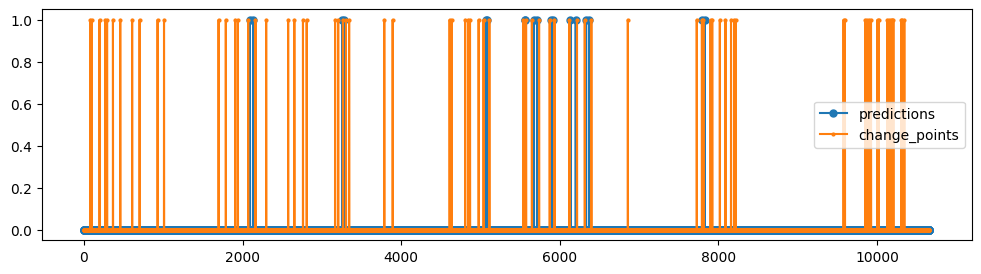

In [22]:
# true changepoint indices selection
true_cp = [df.change_points for df in list_of_df]

predicted_cp[0].plot(figsize=(12, 3), label='predictions', marker='o', markersize=5)
true_cp[0].plot(marker='o', markersize=2)
plt.legend();

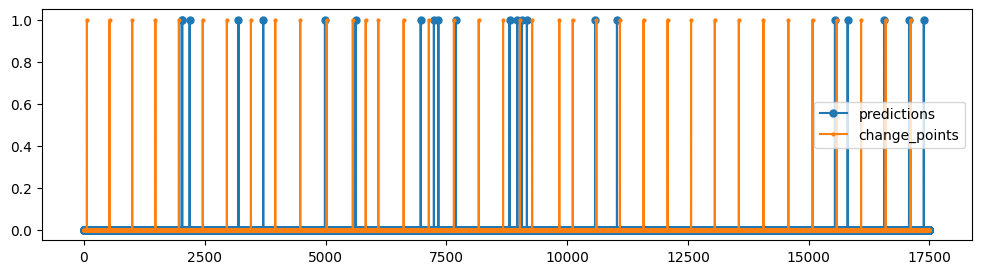

In [23]:
true_cp = [df.change_points for df in list_of_df]

predicted_cp[1].plot(figsize=(12, 3), label='predictions', marker='o', markersize=5)
true_cp[1].plot(marker='o', markersize=2)
plt.legend();

# Metrics calculation

In [56]:
def tsad_average(predicted_list, original_list):
    averate_time, missed_cp, FPs, true_anomalies = evaluating(original_list, predicted_list, metric='average_time', numenta_time='30 sec', verbose=False)
    TP = true_anomalies - missed_cp
    precision = TP/(TP+FPs)
    recall = TP/(TP+missed_cp)
    if precision == 0 or recall ==0:
        F1 = 0
    else:
        F1 = 2*precision*recall/(precision+recall)
    return {'Time_Delta': averate_time, 'Missed_CP': missed_cp, 'FPs': FPs, 'True_Anomalies_Count': true_anomalies, 'precision':precision, 'recall':recall,'F1':F1}

def tsad_nab(predicted_list, original_list):
    nab = evaluating(original_list, predicted_list, metric='nab', numenta_time='30 sec', verbose=False)
    return nab

In [57]:
def create_report(experiment_results: dict):
    experiment_df = pd.DataFrame.from_dict(experiment_results, orient='index')
    experiment_df = experiment_df.fillna(0)
    return experiment_df

In [58]:
from datetime import datetime, timedelta

In [59]:
t_0 = np.arange(len(true_cp[0])).astype('datetime64[s]')
t_1 = np.arange(len(true_cp[1])).astype('datetime64[s]')

In [60]:
df_0 = pd.DataFrame(index=t_0, columns=['predicted_cp'])
df_0['predicted_cp'] = np.array(predicted_cp[0])
df_0['true_cp'] = np.array(true_cp[0])

In [61]:
df_1 = pd.DataFrame(index=t_1, columns=['predicted_cp'])
df_1['predicted_cp'] = np.array(predicted_cp[1])
df_1['true_cp'] = np.array(true_cp[1])

In [67]:
%%capture --no-display
tsad_average_results = tsad_average(df_0['predicted_cp'], df_0['true_cp'])

In [68]:
%%capture --no-display
tsad_nab_results = tsad_nab(df_0['predicted_cp'], df_0['true_cp'])

In [69]:
tsad_nab_results.update(tsad_average_results)
create_report(tsad_nab_results)

,0
Standart,8.38
LowFP,7.53
LowFN,9.19
Time_Delta,0 days 00:00:18.875000
Missed_CP,66
FPs,9
True_Anomalies_Count,74
precision,0.470588
recall,0.108108
F1,0.175824


In [66]:
df_0['true_cp'].count()

10661

In [35]:
# # nab metric calculation
# nab = evaluating(df_0['true_cp'], df_0['predicted_cp'], metric='nab', numenta_time='30 sec')

In [36]:
# # average detection delay metric calculation
# add = evaluating(df_0['true_cp'], df_0['predicted_cp'], metric='average_time', numenta_time='30 sec')

In [37]:
# TP = 52 - 46
# FPS = 10
# FPN = 46
# precision = TP/(TP+FPS)
# recall = TP/(TP+FPN)
# F1 = 2*precision*recall/(precision+recall)
# print(F1)
# print(recall)
# print(precision)

In [31]:
# nab metric calculation
nab = evaluating(df_1['true_cp'], df_1['predicted_cp'], metric='nab', numenta_time='30 sec')

Standart  -  -0.47
LowFP  -  -3.6
LowFN  -  0.59


In [32]:
# average detection delay metric calculation
add = evaluating(df_1['true_cp'], df_1['predicted_cp'], metric='average_time', numenta_time='30 sec')

Amount of true anomalies 37
A number of missed CPs = 36
A number of FPs = 21
Average time 0 days 00:00:27
